Getting dataset

In [6]:
# bring the dataset
# !gdown 1E_jvTfwTVIu0E7mH4CjJ_z2mpWQocvWp

Downloading...
From: https://drive.google.com/uc?id=1E_jvTfwTVIu0E7mH4CjJ_z2mpWQocvWp
To: /content/engine_speeds.pq
100% 673k/673k [00:00<00:00, 82.4MB/s]


Dependencies

In [ ]:
'''
I recommend using Colab to run the notebook. If using local machine please install below packages first in order to execute the notebook.
pandas
scikit-learn
matplotlib
numpy
'''

# Automatic Threshold Detection

Generate a statistical approach that predicts the maximum idle state engine speed  e.g. a threshold that distinguishes idle from work activity based on the engine speed signal of the machine.

- Given is a dataset that provides engine speed tracked over 20000 seconds in time at 1 Hz for 5 vehicles. The engine speed has a direct correspondence to the kind of activity the machine does.
- The density function for the engine speed should show two larger distributions. One sharp peak around the idle point of the Diesel engine (~ 800 - 1000 rpm) and a wider distribution around the working point of this machine. There might be a smooth transition between both distributions.
- A threshold should be detected automatically from these distributions to distinguish between idle and working state (e.g. < 900 rpm -> idle, >= 900 rpm -> work).
- To detect a threshold Gaussian Mixtures Models or a Dirichlet process should be fitted to density function. The idle threshold should selected in a way that it covers a reasonable amount of the time spend in idling (please explain your approach).
- Outliers (0 rpm and excessive rpm values > 2500 rpm) should be dropped.


Your main objective is to define an approach
- To validate input data before pushing it for threshold detection.
- To identify the threshold.
- To validate the threshold generated.

# Deliverables
- Runable Jupyter notebook with all its dependancies and packages mentioned
- Succinctly explain all your assumptions and the reasons behind approaches
- Generate a report that best describes the outcome along with valuable metrics

In [7]:
import pandas as pd
import os
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

## Read Files

In [8]:
df = pd.read_parquet('engine_speeds.pq')
df.shape

(80000, 1)

## Data Statistics

In [9]:
df.isna().sum()

engine_speed    0
dtype: int64

In [10]:
df.reset_index().groupby('machine_id')['engine_speed'].count().to_frame()

,engine_speed
machine_id,
0,20000
1,20000
3,20000
4,20000


array([<Axes: title={'center': '0'}, ylabel='Frequency'>,
       <Axes: title={'center': '1'}, ylabel='Frequency'>,
       <Axes: title={'center': '3'}, ylabel='Frequency'>,
       <Axes: title={'center': '4'}, ylabel='Frequency'>], dtype=object)

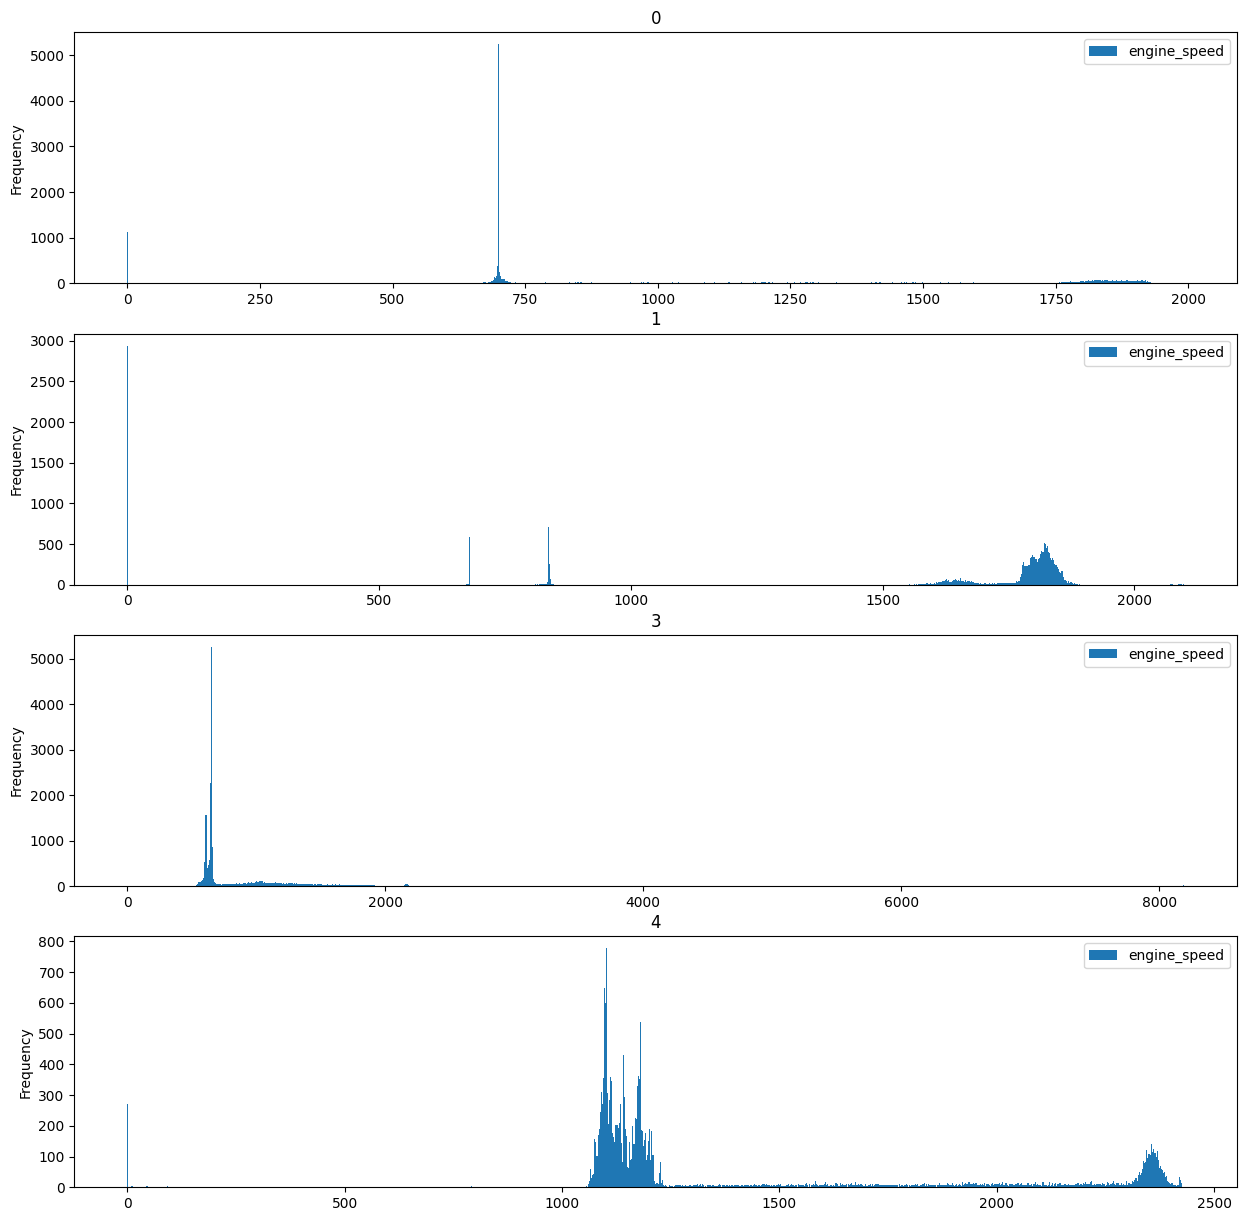

In [11]:
df.reset_index().plot.hist(column='engine_speed', by='machine_id', figsize=(15, 15), bins=1000)

## Solution

EDA

In [12]:
df.head()

engine_speed
machine_id index              
0          0         701.50000
           1         681.53674
           2         987.33124
           3        1162.61250
           4        1315.30630

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 80000 entries, (0, 0) to (4, 19999)
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_speed  80000 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [14]:
# filtering outliers
df = df[(df['engine_speed'] > 0) & (df['engine_speed'] <= 2500)]

In [15]:
# pivot columns based on columns=machine_id and values=engine_speed
df = df['engine_speed'].unstack(level='machine_id')
# Rename the columns
df.columns = [f"machine_{col}_engine_speed" for col in df.columns]

In [16]:
df.describe()

,machine_0_engine_speed,machine_1_engine_speed,machine_3_engine_speed,machine_4_engine_speed
count,18876.000000,17060.000000,19972.000000,19729.000000
mean,1167.909506,1682.217459,845.076973,1421.981778
std,481.496126,324.340303,353.847953,473.970419
min,3.393750,3.166667,56.783245,2.800000
25%,700.075000,1753.399123,643.281049,1109.437500
50%,1016.431300,1805.300000,651.137969,1171.263158
75%,1723.276525,1827.861111,999.417465,1697.388889
max,1991.918700,2098.710526,2205.705000,2430.411765


Data Validation

In [18]:
# counts of outliers each now nan.
df.isna().sum()

machine_0_engine_speed    1124
machine_1_engine_speed    2940
machine_3_engine_speed      28
machine_4_engine_speed     271
dtype: int64

In [ ]:
df.ffill().plot(figsize=(15, 10))

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   machine_0_engine_speed  18876 non-null  float64
 1   machine_1_engine_speed  17060 non-null  float64
 2   machine_3_engine_speed  19972 non-null  float64
 3   machine_4_engine_speed  19729 non-null  float64
dtypes: float64(4)
memory usage: 781.2 KB


Modeling for Threshold Identification

In [34]:
# Initialize a dictionary to store Gaussian Mixture Models for each machine
gmm_models = {}

# 3.1 Fit Gaussian Mixture Model for each machine's engine speed data
for column in df.columns:

  # Drop NaN values for fitting the model
  data = df[column].dropna().values.reshape(-1, 1)

  # Fit a Gaussian Mixture Model with 2 components (idle and work states)
  gmm = GaussianMixture(n_components=2, random_state=42)
  gmm.fit(data)

  # # Store the model
  gmm_models[column] = gmm

# Show fitted models
gmm_models.keys()


dict_keys(['machine_0_engine_speed', 'machine_1_engine_speed', 'machine_3_engine_speed', 'machine_4_engine_speed'])

Threshold Identification

In [52]:
# Step 4: Threshold Identification

# Initialize a dictionary to store thresholds for each machine
thresholds = {}

# 4.1 Use the mean of the idle state distribution as a starting point for the threshold
# 4.2 Adjust the threshold to cover a reasonable amount of time spent in idling
for machine, model in gmm_models.items():
    # Extract means of the two Gaussian distributions
    means = model.means_.flatten()

    # Identify the mean corresponding to the idle state (the smaller mean)
    idle_mean = min(means)

    # Adjust the threshold to be the idle mean (no further adjustments made as of now)
    thresholds[machine] = idle_mean

# Show calculated thresholds
thresholds


{'machine_0_engine_speed': 699.9095660559975,
 'machine_1_engine_speed': 784.2789624410192,
 'machine_3_engine_speed': 639.4075149596063,
 'machine_4_engine_speed': 1135.6728687507195}

Threshold Validation

In [53]:
# Step 5: Threshold Validation

# Initialize a dictionary to store the percentage of time spent below and above the threshold for each machine
time_percentage = {}

# 5.1 Calculate the percentage of time spent below and above the threshold for each machine
for machine, threshold in thresholds.items():
    # Drop NaN values for validation
    data = df[machine].dropna()

    # Calculate the percentage of time spent below the threshold (idle state)
    idle_time_percentage = (data < threshold).mean() * 100
    # Calculate the percentage of time spent above the threshold (work state)
    work_time_percentage = (data >= threshold).mean() * 100

    # Store the results
    time_percentage[machine] = {'Idle': idle_time_percentage, 'Work': work_time_percentage}

# Show the calculated percentages
time_percentage

{'machine_0_engine_speed': {'Idle': 19.659885568976478,
  'Work': 80.34011443102352},
 'machine_1_engine_speed': {'Idle': 3.7866354044548656,
  'Work': 96.21336459554513},
 'machine_3_engine_speed': {'Idle': 21.835569797716804,
  'Work': 78.1644302022832},
 'machine_4_engine_speed': {'Idle': 37.41700035480765,
  'Work': 62.58299964519236}}

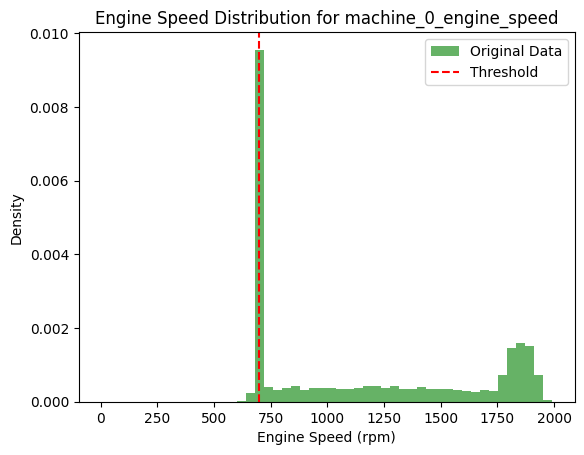

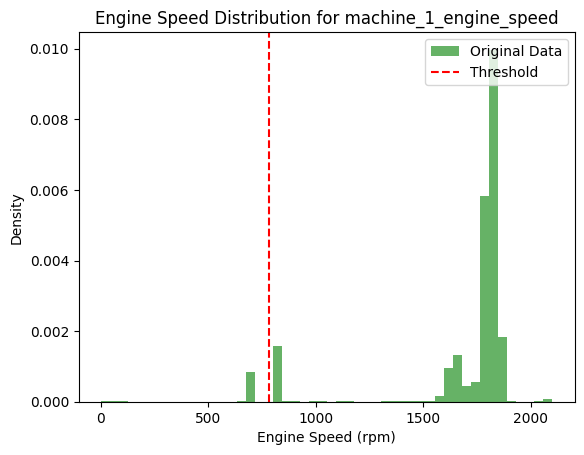

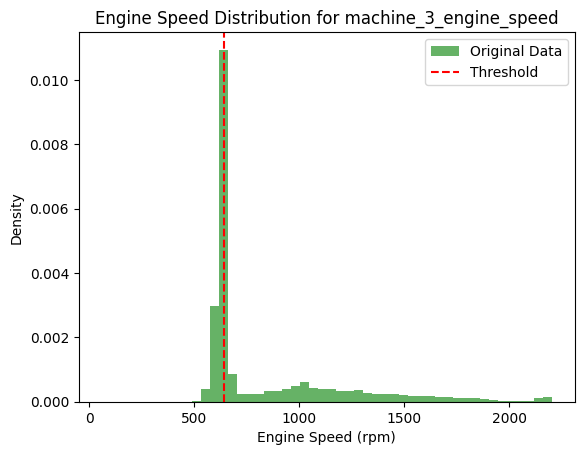

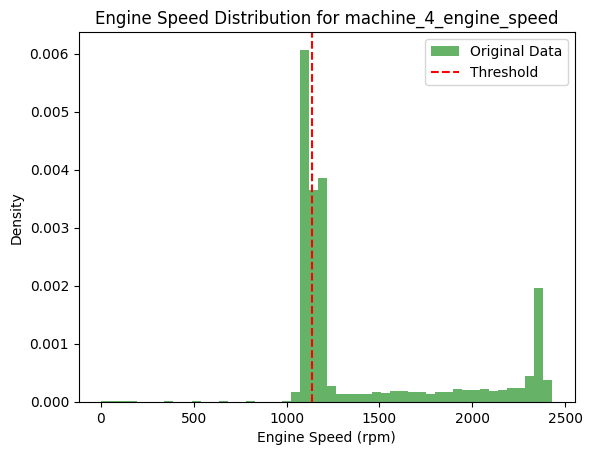

In [60]:
# Initialize a dictionary to store evaluation metrics for each machine
evaluation_metrics = {}

# Evaluate each fitted Gaussian Mixture Model
for machine, model in gmm_models.items():
    # Drop NaN values for evaluation
    data = df[machine].dropna().values.reshape(-1, 1)

    # 1. Likelihood Score
    likelihood_score = model.score(data)

    # 2. Percentage of Time in Idle and Work State (Already calculated, included for completeness)
    time_percent = time_percentage[machine]

    # Store the metrics
    evaluation_metrics[machine] = {'Likelihood Score': likelihood_score, **time_percent}

    # 3. Visual Inspection: Plot the original data and the identified threshold
    plt.hist(data, bins=50, density=True, alpha=0.6, color='g', label='Original Data')
    plt.axvline(thresholds[machine], color='r', linestyle='dashed', linewidth=1.5, label='Threshold')
    plt.title(f"Engine Speed Distribution for {machine}")
    plt.xlabel("Engine Speed (rpm)")
    plt.ylabel("Density")
    plt.legend(loc='upper right')
    plt.show()


Summary and Final Output

* Machine 0:
Threshold: 699.91 rpm
Idle: 19.66%
Work: 80.34%
* Machine 1:
Threshold: 784.28 rpm
Idle: 3.79%
Work: 96.21%
* Machine 3:
Threshold: 639.41 rpm
Idle: 21.84%
Work: 78.16%
* Machine 4:
Threshold: 1135.67 rpm
Idle: 37.42%
Work: 62.58%

In [55]:
# Step 6: Summary and Final Output

# Combine the identified thresholds and the calculated time percentages for each machine
final_output = {machine: {'Threshold': thresholds[machine], **time_percentage[machine]} for machine in thresholds.keys()}

# Show the final output
final_output

{'machine_0_engine_speed': {'Threshold': 699.9095660559975,
  'Idle': 19.659885568976478,
  'Work': 80.34011443102352},
 'machine_1_engine_speed': {'Threshold': 784.2789624410192,
  'Idle': 3.7866354044548656,
  'Work': 96.21336459554513},
 'machine_3_engine_speed': {'Threshold': 639.4075149596063,
  'Idle': 21.835569797716804,
  'Work': 78.1644302022832},
 'machine_4_engine_speed': {'Threshold': 1135.6728687507195,
  'Idle': 37.41700035480765,
  'Work': 62.58299964519236}}